# Udacity AWS ML - project 3

This notebook downloads, trains and deploys the model for dog breed classification

In [77]:
# Install all required packages
!pip install smdebug
!pip install -U sagemaker

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrad

In [78]:
# When installing torch you need to add '--no-cache-dir', because your notebook machine can go out of memory and just crash.
!pip install torchvision torch --no-cache-dir

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [79]:
# Import required packages - further imports will be added later
import sagemaker
import boto3

## Dataset
The dataset contains images from 133 dog breeds divided into training, testing and validation datasets.
Following cells download, preprocess and plot sample of the dataset.
Torch dataset loader was also created to ease teh process of training the network

In [4]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-04-12 09:30:30--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.194.32
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.194.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  3.94MB/s    in 1m 49s  

2022-04-12 09:32:20 (9.89 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Af

In [80]:
# General macros
session = sagemaker.Session()
bucket= session.default_bucket()
print("Default Bucket: {}".format(bucket))
region = session.boto_region_name
print("AWS Region: {}".format(region))
role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-071394031625
AWS Region: us-east-1
RoleArn: arn:aws:iam::071394031625:role/service-role/AmazonSageMaker-ExecutionRole-20220406T185210


In [6]:
# Create metadata csv files with keys: path, classification to mimic MNIST dataset description.
# It will be easier to create proper dataloader for these data
import os
import csv

def create_metadata(database_path):
    with open(os.path.join(database_path, 'meta.csv'), 'w', encoding='UTF8') as output_file:
        writer = csv.writer(output_file)
        writer.writerow(['Id', 'Filename'])
        for root, dirs, files in os.walk(database_path):
            files.sort()
            for file in files:
                if file.lower().endswith('.jpg'):
                    classification_id = int(root.split("/")[2].split(".")[0])-1
                    rel_path = os.path.join(root, file)
                    row = [classification_id, rel_path]
                    writer.writerow(row)
    print('Creating metadata completed for file', os.path.join(database_path, 'meta.csv'))
                    
create_metadata('dogImages/test')
create_metadata('dogImages/train')
create_metadata('dogImages/valid')

Creating metadata completed for file dogImages/test/meta.csv
Creating metadata completed for file dogImages/train/meta.csv
Creating metadata completed for file dogImages/valid/meta.csv


In [7]:
# Create labels map
database_path = 'dogImages'

def create_labels_map(database_path):
    output_filename = os.path.join(database_path, 'labels.csv')
    with open(output_filename, 'w', encoding='UTF8') as output_file:
        writer = csv.writer(output_file)
        writer.writerow(['Id', 'Breed name'])
        for root, dirs, files in os.walk(os.path.join(database_path, 'test')):
            dirs.sort()
            for directories in dirs:
                splitted_dir_name = directories.split(".")
                if (len(splitted_dir_name) == 2 and len(splitted_dir_name[0])>0):
                    splitted_dir_name[0] = int(splitted_dir_name[0]) - 1
                    writer.writerow(splitted_dir_name)
            break
    print('Creating labels map completed. Output', output_filename)
    
create_labels_map(database_path)

Creating labels map completed. Output dogImages/labels.csv


In [8]:
# Print statistics about the dataset
import pandas as pd
labels_map = pd.read_csv('dogImages/labels.csv')
test_meta = pd.read_csv('dogImages/test/meta.csv')
valid_meta = pd.read_csv('dogImages/valid/meta.csv')
train_meta = pd.read_csv('dogImages/train/meta.csv')

print('There are %d total dog categories.' % len(labels_map))
print('There are %s total dog images.\n' % str(len(test_meta)+len(valid_meta)+len(train_meta)))
print('There are %d training dog images.' % len(train_meta))
print('There are %d validation dog images.' % len(valid_meta))
print('There are %d test dog images.'% len(test_meta))

There are 133 total dog categories.
There are 8364 total dog images.

There are 6681 training dog images.
There are 835 validation dog images.
There are 848 test dog images.


label Boston_terrier id 31
label Irish_setter id 85
label Border_collie id 28
label Australian_shepherd id 11
label Bull_terrier id 38
label Bedlington_terrier id 18
label Dalmatian id 56
label Great_pyrenees id 78
label Clumber_spaniel id 51


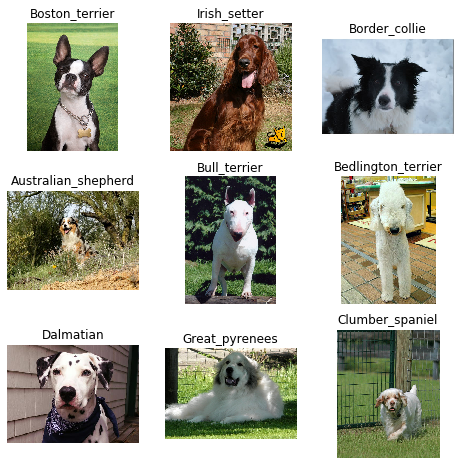

<Figure size 432x288 with 0 Axes>

In [64]:
# Plot some of the data
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
labels_map = pd.read_csv('dogImages/labels.csv')
test_meta = pd.read_csv('dogImages/test/meta.csv')

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = random.randint(0, len(test_meta))
    img_path = test_meta.iloc[sample_idx, 1]
    label_id = test_meta.iloc[sample_idx, 0]
    label = labels_map.iloc[int(label_id), 1]
    print("label", label, "id", label_id)
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(mpimg.imread(img_path).squeeze(), cmap="gray")
plt.show()
plt.savefig('sample_dataset_images.png')

In [173]:
# Create test image loader for HPO
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class DogBreedDataset(Dataset):
    def __init__(self, annotations_file, base_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.base_dir = base_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.base_dir, self.img_labels.iloc[idx, 1])
        image = read_image(img_path)
        label = int(self.img_labels.iloc[idx, 0])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


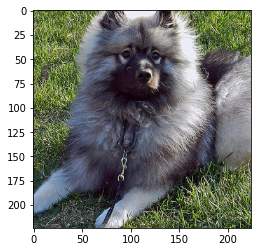

Label: 91


In [39]:
# Display image and label.
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
# Some magic values which are equally the same across multiple examples for different datasets.
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image_transform = transforms.Compose([
    transforms.Resize([256, ]),
    transforms.CenterCrop(224),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=mean, std=std)])
training_data = DogBreedDataset(annotations_file = 'dogImages/train/meta.csv', base_dir = '.', transform = image_transform)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze().numpy().transpose(1,2,0)
label = train_labels[0]
plt.imshow(img*std+mean)
plt.show()
print(f"Label: {label}")

In [8]:
# Upload data to S3 for training
import os

os.environ["DATABASE_PATH"] = "s3://"+ bucket+ "/dogImages/"
!aws s3 cp dogImages ${DATABASE_PATH} --recursive

upload: dogImages/labels.csv to s3://sagemaker-us-east-1-071394031625/dogImages/labels.csv
upload: dogImages/.ipynb_checkpoints/labels-checkpoint.csv to s3://sagemaker-us-east-1-071394031625/dogImages/.ipynb_checkpoints/labels-checkpoint.csv
upload: dogImages/test/.ipynb_checkpoints/meta-checkpoint.csv to s3://sagemaker-us-east-1-071394031625/dogImages/test/.ipynb_checkpoints/meta-checkpoint.csv
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg to s3://sagemaker-us-east-1-071394031625/dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg to s3://sagemaker-us-east-1-071394031625/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg to s3://sagemaker-us-east-1-071394031625/dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg to s3://sagemaker-us-east-1-071394031625/dogIma

## Hyperparameter Tuning
Finetuning a pretrained model with hyperparameter tuning. Two hyperparameters were selected for tuning:
- learning rate - to observe when the model learns fasters without overfitting
- batch-size - to find an optimal value for the batch to optimize learning process time

All details are provided in the `hpo.py` script.

In [147]:
# Declare HP ranges and metrics
hyperparameter_ranges = {
    "lr": sagemaker.tuner.ContinuousParameter(0.001, 0.1),
    "batch-size": sagemaker.tuner.CategoricalParameter([32, 64, 128, 256, 512]),
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [148]:
# Test raw file execution - if indentation is correct and all dependencies.
# ! python hpo.py

In [149]:
# Create estimator
from sagemaker.pytorch import PyTorch
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

In [150]:
# Create tuner
tuner = sagemaker.tuner.HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [151]:
os.environ["SM_CHANNEL_TRAINING"] = "s3://"+ bucket+ "/dogImages/"
os.environ['SM_MODEL_DIR']="s3://"+ bucket+ "/model/" # where model will be stored
tuner.fit({"training": "s3://"+ bucket+ "/dogImages/"}, wait=False)

In [30]:
tuner.best_training_job()

'pytorch-training-220413-1136-003-a3ad24f0'

In [31]:
# Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

# Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-04-13 11:59:29 Starting - Preparing the instances for training
2022-04-13 11:59:29 Downloading - Downloading input data
2022-04-13 11:59:29 Training - Training image download completed. Training in progress.
2022-04-13 11:59:29 Uploading - Uploading generated training model
2022-04-13 11:59:29 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"32"',
 'lr': '0.0014738112822062317',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-04-13-11-36-12-444"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-071394031625/pytorch-training-2022-04-13-11-36-12-444/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
Using the best hyperparameters, create and finetune a new model

Script`train_model.py` implements model profiling and debugging.

### Train model

In [141]:
hyperparameter_values = {
    "lr": 0.0014738112822062317,
    "batch-size": 32,
}

In [142]:
# Set up debugging rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [143]:
# Set up profiling rules
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

debugger_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

In [144]:
import sagemaker
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.xlarge",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version='py36',
    hyperparameters=hyperparameter_values,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [145]:
# Test raw file execution - if indentation is correct and all dependencies.
# ! python train_model.py

In [146]:
os.environ["SM_CHANNEL_TRAINING"] = "s3://"+ bucket+ "/dogImages/"
os.environ['SM_MODEL_DIR']="s3://"+ bucket+ "/model_train/" # where model will be stored
estimator.fit({"training": "s3://"+ bucket+ "/dogImages/"}, wait=False)
job_name = estimator._current_job_name
print('Job name:', job_name)
debug_artifacts_path = estimator.latest_job_debugger_artifacts_path()
print('Debug artifacts path', debug_artifacts_path)

pytorch-training-2022-04-13-23-57-46-790


### Extract debug info

In [152]:
import boto3
session = boto3.session.Session()
region = session.region_name

if not job_name:
    job_name = "pytorch-training-2022-04-13-23-57-46-790" # put a job name here to load it
estimator = sagemaker.estimator.Estimator.attach(job_name)

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")


2022-04-14 00:08:55 Starting - Preparing the instances for training
2022-04-14 00:08:55 Downloading - Downloading input data
2022-04-14 00:08:55 Training - Training image download completed. Training in progress.
2022-04-14 00:08:55 Uploading - Uploading generated training model
2022-04-14 00:08:55 Completed - Training job completed
Training jobname: pytorch-training-2022-04-13-23-57-46-790
Region: us-east-1


In [153]:
# Wait for training to finish
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-071394031625/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }'}}
s3 path:s3://sagemaker-us-east-1-071394031625/pytorch-training-2022-04-13-23-57-46-790/profiler-output


Profiler data from system is available


In [154]:
# Plot a CPU utilization plot.
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2022-04-14 00:10:49.454 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO metrics_reader_base.py:134] Getting 9 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1'}


The CPU usage is consictent throught the training, which is a good sign, that the job uses all avaiable resources.

### Print the latest training job’s rule summary in real time

In [155]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [156]:
import time
from IPython import display

%matplotlib inline

while description["SecondaryStatus"] not in {"Stopped", "Completed", "Failed"}:
    description = client.describe_training_job(TrainingJobName=job_name)
    primary_status = description["TrainingJobStatus"]
    secondary_status = description["SecondaryStatus"]
    print("====================================================================")
    print("TrainingJobStatus: ", primary_status, " | SecondaryStatus: ", secondary_status)
    print("====================================================================")
    for r in range(len(estimator.latest_training_job.rule_job_summary())):
        rule_summary = estimator.latest_training_job.rule_job_summary()
        print(
            rule_summary[r]["RuleConfigurationName"], ": ", rule_summary[r]["RuleEvaluationStatus"]
        )
        if rule_summary[r]["RuleEvaluationStatus"] == "IssuesFound":
            print(rule_summary[r]["StatusDetails"])
        print("====================================================================")
    print("Current time: ", time.asctime())
    display.clear_output(wait=True)
    time.sleep(10) # in seconds

The debug information does not find any issues. 
Failed processing jobs has status: "InternalServerError: We encountered an internal error. Please try again.", which means that they failed due to some AWS internal problems. In order to solve that I would run the training oustide of AWS.

In [159]:
# Check Training Performance
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

if not debug_artifacts_path:
    debug_artifacts_path = "s3://sagemaker-us-east-1-071394031625/pytorch-training-2022-04-13-23-57-46-790/debug-output/"

trial = create_trial(debug_artifacts_path)

[2022-04-14 00:15:27.224 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO s3_trial.py:42] Loading trial  at path s3://sagemaker-us-east-1-071394031625/pytorch-training-2022-04-13-23-57-46-790/debug-output/


In [160]:
trial.tensor_names()

[2022-04-14 00:15:39.490 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-04-14 00:15:40.515 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [161]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

42

In [162]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

33

In [163]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)
    
    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    plt.savefig('training_debug_values.png')

In [ ]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  

### Display profiler report

In [166]:
# Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-071394031625/pytorch-training-2022-04-13-23-57-46-790/rule-output


In [167]:
! aws s3 ls {rule_output_path} --recursive

2022-04-14 00:08:04     365152 pytorch-training-2022-04-13-23-57-46-790/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-04-14 00:08:04     212206 pytorch-training-2022-04-13-23-57-46-790/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-04-14 00:07:59        191 pytorch-training-2022-04-13-23-57-46-790/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-04-14 00:07:59        199 pytorch-training-2022-04-13-23-57-46-790/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-04-14 00:07:59       2167 pytorch-training-2022-04-13-23-57-46-790/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-04-14 00:07:59        127 pytorch-training-2022-04-13-23-57-46-790/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-04-14 00:07:59        198 pytorch-training-2022-04-13-23-57-46-790/rule-output/ProfilerReport/profiler-output/profiler-re

In [168]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-071394031625/pytorch-training-2022-04-13-23-57-46-790/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-071394031625/pytorch-training-2022-04-13-23-57-46-790/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-071394031625/pytorch-training-2022-04-13-23-57-46-790/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-071394031625/pytorch-training-2022-04-13-23-57-46-790/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-07139403162

In [169]:
import os, IPython
# get the autogenerated folder name of profiler report
profiler_report_name = [rule["RuleConfigurationName"] for rule in estimator.latest_training_job.rule_job_summary()
                        if "Profiler" in rule["RuleConfigurationName"]
                       ][0]

print(profiler_report_name)
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

ProfilerReport


## Model Deploying

In [190]:
# Deploy your model to an endpoint
# In order to do that you don't need to have a Notebook running through the whole training process in order to store the 'estimator' class properly. 
# You can attach training job results to an estimator object
# predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge") 
predictor = tuner.deploy(1, "ml.m5.xlarge")


2022-04-14 00:17:49 Starting - Preparing the instances for training
2022-04-14 00:17:49 Downloading - Downloading input data
2022-04-14 00:17:49 Training - Training image download completed. Training in progress.
2022-04-14 00:17:49 Uploading - Uploading generated training model
2022-04-14 00:17:49 Completed - Training job completed
-----!

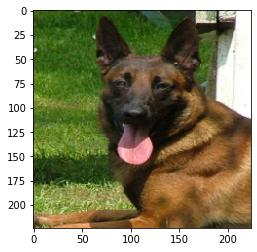

Label: Belgian_malinois


In [191]:
# Run an prediction on the endpoint
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd

labels_map = pd.read_csv('dogImages/labels.csv')
image_transform = transforms.Compose([
    transforms.Resize((224, 224))
    ])
test_data = DogBreedDataset(annotations_file = 'dogImages/test/meta.csv', base_dir = '.', transform = image_transform)

test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
test_features, test_labels = next(iter(test_dataloader))

raw_image_for_network = test_features[0]
image_for_plot = raw_image_for_network.squeeze().numpy().transpose(1,2,0)
label_id = test_labels[0]
label = labels_map.iloc[int(label_id), 1]
plt.imshow(image_for_plot)
plt.show()
print(f"Label: {label}")

In [193]:
response = predictor.predict(raw_image_for_network)
print("Raw prediction result:")
print(response)
print()

labeled_predictions = list(zip(range(10), response[0]))
print("Labeled predictions: ")
print(labeled_predictions)
print()

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-training-220414-0003-001-bb646d24 in account 071394031625 for more information.

In [194]:
# Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()